In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import time

from torch.nn.functional import cross_entropy

In [ ]:
def random_initialization(layers_dims):
    """
    Inicializa los parámetros para cualquier número de capas.
    """
    parameters = {}
    L = len(layers_dims)
    
    for l in range(1, L):
        parameters[f'W{l}'] = np.random.randn(layers_dims[l-1], layers_dims[l]) * 0.01
        parameters[f'b{l}'] = np.zeros((1, layers_dims[l]))
    
    return parameters


In [ ]:
def relu(x):
    return np.maximum(0, x)

In [ ]:
def relu_derivative(x):
  return np.where(x > 0, 1, 0)

In [ ]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [ ]:
def forward_propagation(X, parameters):
    """
    Realiza la propagación hacia adelante para cualquier número de capas.
    """
    L = len(parameters) // 2  # Número de capas (W, b cuentan como dos claves por capa)
    cache = {'A0': X}
    
    A = X
    for l in range(1, L + 1):
        Z = np.dot(A, parameters[f'W{l}']) + parameters[f'b{l}']
        if l == L:  # Última capa: Softmax
            A = softmax(Z)
        else:  # Capas ocultas: ReLU
            A = relu(Z)
        cache[f'Z{l}'] = Z
        cache[f'A{l}'] = A

    return A, cache

def backward_propagation(X, y, cache, parameters):
    """
    Realiza la propagación hacia atrás para cualquier número de capas.
    """
    L = len(parameters) // 2  # Número de capas
    m = X.shape[0]
    gradients = {}

    # Gradientes para la última capa
    dZ = cache[f'A{L}'] - y
    for l in reversed(range(1, L + 1)):
        dW = np.dot(cache[f'A{l-1}'].T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        gradients[f'dW{l}'] = dW
        gradients[f'db{l}'] = db

        if l > 1:  # No calcular da para la primera capa
            dA = np.dot(dZ, parameters[f'W{l}'].T)
            dZ = dA * relu_derivative(cache[f'Z{l-1}'])

    return gradients

def predict(X, parameters, y_test):

    a3, _ = forward_propagation(X, parameters)
    predictions = np.argmax(a3, axis=1)

    y_test_labels = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_test_labels, predictions)

    return predictions, accuracy


In [ ]:
def cross_entropy(a3, y_true):

    m = y_true.shape[0]

    cost = -np.sum(y_true * np.log(a3 + 1e-8)) / m  

    return cost

In [ ]:
class EstocasticOptimizer():
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
    
    def update(self, parameters, grads):
        L = len(parameters) // 2 
    
        for l in range(L):
            parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - self.learning_rate * grads["dW" + str(l + 1)]
            parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - self.learning_rate * grads["db" + str(l + 1)]
        return parameters

In [ ]:
class AdamOptimizer():
    def __init__(self, parameters, learning_rate):
        self.v = {}
        self.s = {}
        self.learning_rate = learning_rate
        L = len(parameters) // 2

        for l in range(L):
            self.v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
            self.v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

            self.s["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l + 1)])
            self.s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l + 1)])

    def update(self, parameters, grads, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
        L = len(parameters) // 2                 
        v_corrected = {}                         
        s_corrected = {}                         

        
        for l in range(L):
            
            self.v["dW" + str(l + 1)] = beta1 * self.v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
            self.v["db" + str(l + 1)] = beta1 * self.v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]

            v_corrected["dW" + str(l + 1)] = self.v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
            v_corrected["db" + str(l + 1)] = self.v["db" + str(l + 1)] / (1 - np.power(beta1, t))

            self.s["dW" + str(l + 1)] = beta2 * self.s["dW" + str(l + 1)] + (1 - beta2) * np.power(grads['dW' + str(l + 1)], 2)
            self.s["db" + str(l + 1)] = beta2 * self.s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)

            s_corrected["dW" + str(l + 1)] = self.s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
            s_corrected["db" + str(l + 1)] = self.s["db" + str(l + 1)] / (1 - np.power(beta2, t))

            parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - self.learning_rate * v_corrected["dW" + str(l + 1)] / np.sqrt(self.s["dW" + str(l + 1)] + epsilon)
            parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - self.learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(self.s["db" + str(l + 1)] + epsilon)

        return parameters

In [84]:
def create_batches(X, Y, batch_size):
    """
    Divide los datos en lotes (batches) de tamaño batch_size.
    """
    m = X.shape[0]
    indices = np.random.permutation(m)
    X_shuffled = X[indices]
    Y_shuffled = Y[indices]

    batches = []
    for i in range(0, m, batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        Y_batch = Y_shuffled[i:i+batch_size]
        batches.append((X_batch, Y_batch))

    return batches

def model(X, Y, layers_dims, learning_rate=0.01, num_epochs=500, batch_size=32, optimizer_use="Adam"):
    """
    Entrena el modelo utilizando mini-batches.
    """
    L = len(layers_dims)
    costs = []
    t = 0

    parameters = random_initialization(layers_dims)
    if optimizer_use == "Adam": optimizer = AdamOptimizer(parameters, learning_rate=learning_rate)
    if optimizer_use == "Estocastic": optimizer = EstocasticOptimizer(learning_rate=learning_rate)

    for i in range(num_epochs):
        batches = create_batches(X, Y, batch_size)  # Crear lotes
        for batch in batches:
            X_batch, Y_batch = batch

            # Propagación hacia adelante
            aL, cache = forward_propagation(X_batch, parameters)

            # Costo
            cost = cross_entropy(aL, Y_batch)

            # Propagación hacia atrás
            grads = backward_propagation(X_batch, Y_batch, cache, parameters)

            # Actualización de parámetros
            t += 1
            if optimizer_use == "Adam":
                parameters = optimizer.update(parameters, grads, t)
            elif optimizer_use == "Estocastic":
                parameters = optimizer.update(parameters, grads)

        # Imprimir y registrar costos periódicamente
        if i % 1000 == 0:
            print(f"Costo tras epoch {i}: {cost:.6f}")
        if i % 100 == 0:
            costs.append(cost)

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title(f"Optimizador: {optimizer_use}; Learning rate = {learning_rate}; Batch size = {batch_size}")
    plt.show()

    return parameters


In [ ]:
iris = load_iris()
X = iris.data  
y = iris.target.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y)  

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
X_reduced = tsne.fit_transform(X)

df = pd.DataFrame(X_reduced, columns=['Dim1', 'Dim2', 'Dim3'])
df['target'] = y

colors = ['red', 'blue', 'green']
target_names = iris.target_names

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, target_name in enumerate(target_names):
    ax.scatter(df.loc[df['target'] == i, 'Dim1'],
               df.loc[df['target'] == i, 'Dim2'],
               df.loc[df['target'] == i, 'Dim3'],
               label=target_name, color=colors[i])

ax.set_xlabel('Dim1')
ax.set_ylabel('Dim2')
ax.set_zlabel('Dim3')
ax.set_title('Iris Dataset en 3D usando t-SNE')
ax.legend()
plt.show()

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.5    NºBATCHES: 8
Costo tras epoch 0: 4.769249
Costo tras epoch 1000: 1.232016
Costo tras epoch 2000: 1.242282
Costo tras epoch 3000: 1.187158
Costo tras epoch 4000: 1.070915
Costo tras epoch 5000: 1.062073
Costo tras epoch 6000: 1.324222
Costo tras epoch 7000: 1.161200
Costo tras epoch 8000: 1.118218
Costo tras epoch 9000: 1.213886


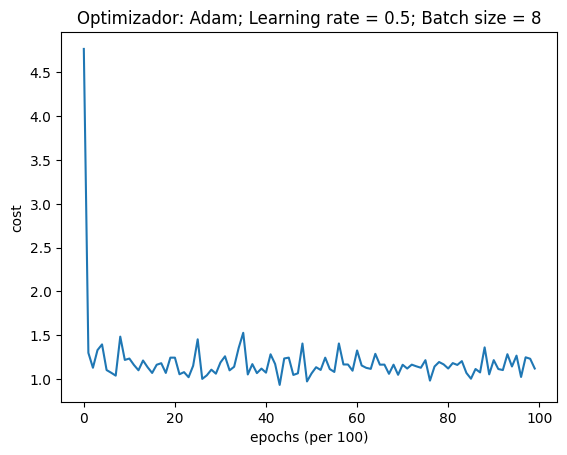

La exactitud para optimizador Adam con learning rate 0.5 y nº batches: 8 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.5    NºBATCHES: 16
Costo tras epoch 0: 9.612120
Costo tras epoch 1000: 1.144812
Costo tras epoch 2000: 1.176214
Costo tras epoch 3000: 1.106357
Costo tras epoch 4000: 1.046004
Costo tras epoch 5000: 1.376623
Costo tras epoch 6000: 1.074925
Costo tras epoch 7000: 0.945928
Costo tras epoch 8000: 1.063688
Costo tras epoch 9000: 1.219870


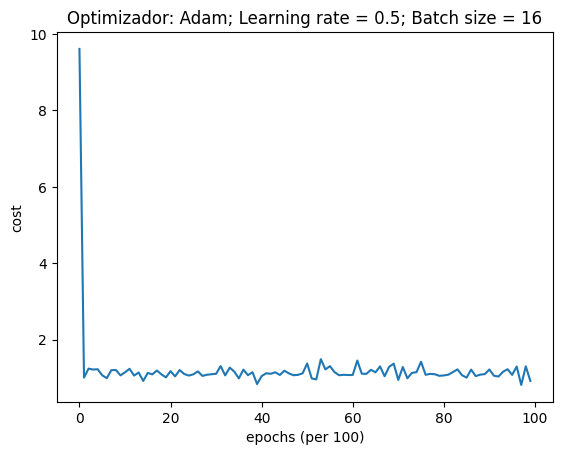

La exactitud para optimizador Adam con learning rate 0.5 y nº batches: 16 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.5    NºBATCHES: 32
Costo tras epoch 0: 4.780273
Costo tras epoch 1000: 1.139662
Costo tras epoch 2000: 1.078244
Costo tras epoch 3000: 1.053485
Costo tras epoch 4000: 1.102605
Costo tras epoch 5000: 1.155463
Costo tras epoch 6000: 1.092367
Costo tras epoch 7000: 1.122837
Costo tras epoch 8000: 1.100126
Costo tras epoch 9000: 1.183319


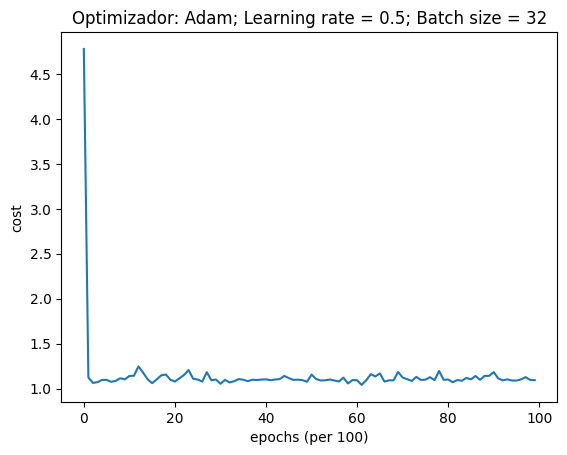

La exactitud para optimizador Adam con learning rate 0.5 y nº batches: 32 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.1    NºBATCHES: 8
Costo tras epoch 0: 4.931206
Costo tras epoch 1000: 1.203223
Costo tras epoch 2000: 1.056794
Costo tras epoch 3000: 1.136317
Costo tras epoch 4000: 1.054674
Costo tras epoch 5000: 1.159030
Costo tras epoch 6000: 1.096834
Costo tras epoch 7000: 1.189096
Costo tras epoch 8000: 1.111255
Costo tras epoch 9000: 1.036690


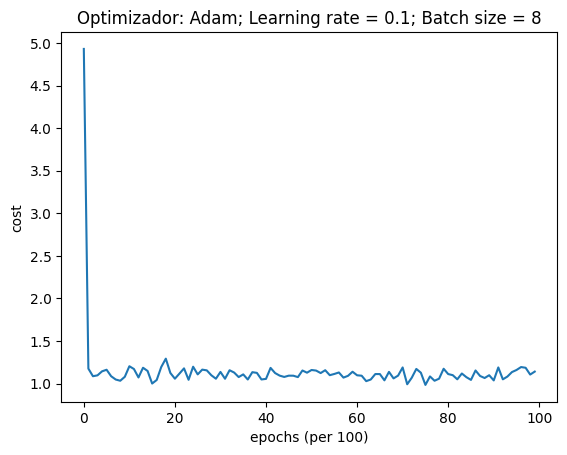

La exactitud para optimizador Adam con learning rate 0.1 y nº batches: 8 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.1    NºBATCHES: 16
Costo tras epoch 0: 1.848947
Costo tras epoch 1000: 1.118170
Costo tras epoch 2000: 1.161004
Costo tras epoch 3000: 1.144683
Costo tras epoch 4000: 1.119870
Costo tras epoch 5000: 1.045971
Costo tras epoch 6000: 1.019964
Costo tras epoch 7000: 1.067277
Costo tras epoch 8000: 1.074545
Costo tras epoch 9000: 1.058061


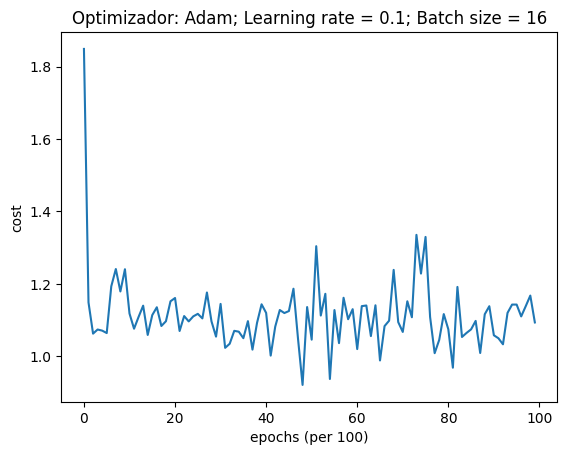

La exactitud para optimizador Adam con learning rate 0.1 y nº batches: 16 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.1    NºBATCHES: 32
Costo tras epoch 0: 1.819665
Costo tras epoch 1000: 1.075916
Costo tras epoch 2000: 1.093626
Costo tras epoch 3000: 1.102707
Costo tras epoch 4000: 1.075617
Costo tras epoch 5000: 1.097060
Costo tras epoch 6000: 1.083966
Costo tras epoch 7000: 1.112463
Costo tras epoch 8000: 1.148457
Costo tras epoch 9000: 1.114511


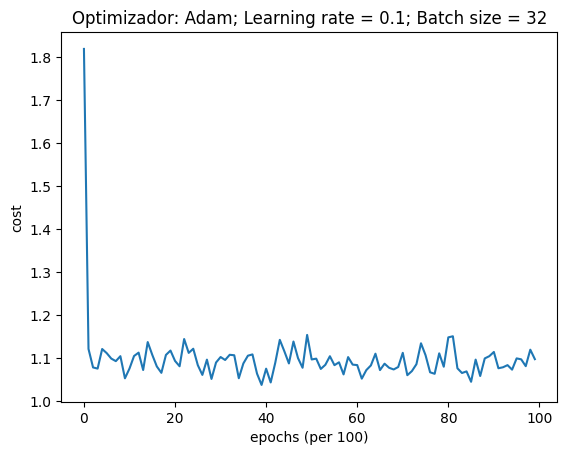

La exactitud para optimizador Adam con learning rate 0.1 y nº batches: 32 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.05    NºBATCHES: 8
Costo tras epoch 0: 1.125476
Costo tras epoch 1000: 1.144670
Costo tras epoch 2000: 1.020147
Costo tras epoch 3000: 1.110125
Costo tras epoch 4000: 1.107696
Costo tras epoch 5000: 1.164646
Costo tras epoch 6000: 1.166626
Costo tras epoch 7000: 1.154084
Costo tras epoch 8000: 1.042704
Costo tras epoch 9000: 1.039307


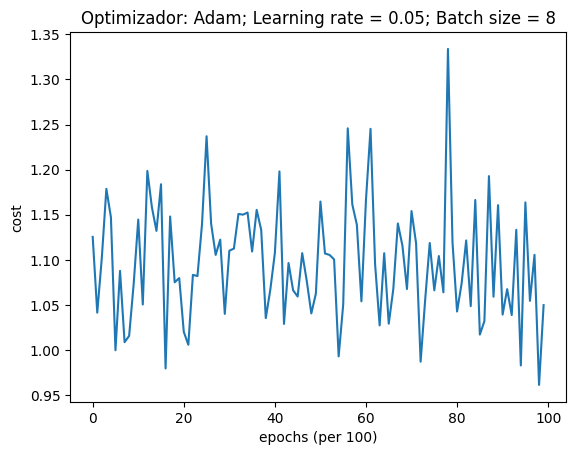

La exactitud para optimizador Adam con learning rate 0.05 y nº batches: 8 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.05    NºBATCHES: 16
Costo tras epoch 0: 0.971092
Costo tras epoch 1000: 1.103158
Costo tras epoch 2000: 1.144992
Costo tras epoch 3000: 1.033658
Costo tras epoch 4000: 1.034072
Costo tras epoch 5000: 1.107961
Costo tras epoch 6000: 1.126013
Costo tras epoch 7000: 1.077478
Costo tras epoch 8000: 1.167314
Costo tras epoch 9000: 1.187946


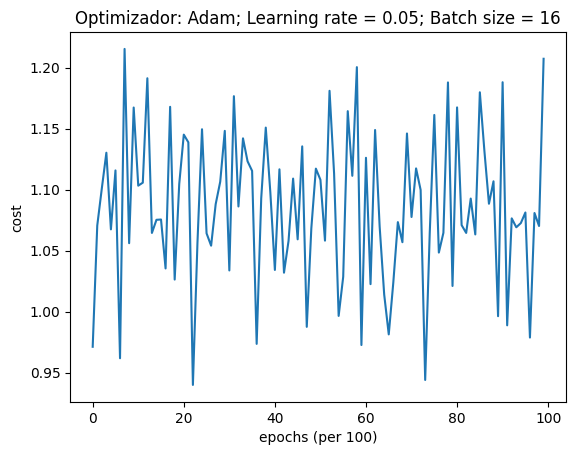

La exactitud para optimizador Adam con learning rate 0.05 y nº batches: 16 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.05    NºBATCHES: 32
Costo tras epoch 0: 1.237432
Costo tras epoch 1000: 1.046367
Costo tras epoch 2000: 1.097541
Costo tras epoch 3000: 1.128343
Costo tras epoch 4000: 1.097379
Costo tras epoch 5000: 1.129282
Costo tras epoch 6000: 1.110953
Costo tras epoch 7000: 1.063416
Costo tras epoch 8000: 1.050181
Costo tras epoch 9000: 1.077393


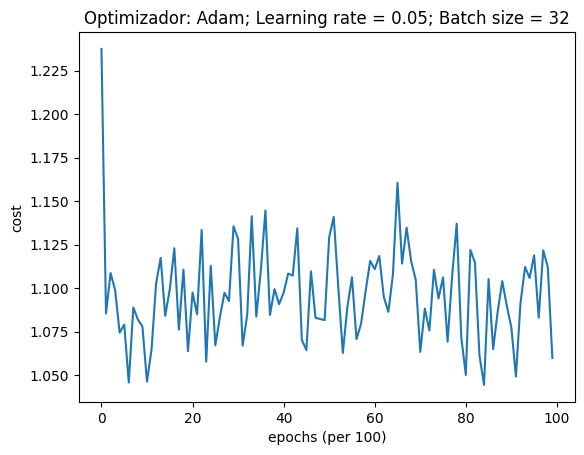

La exactitud para optimizador Adam con learning rate 0.05 y nº batches: 32 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.01    NºBATCHES: 8
Costo tras epoch 0: 0.999087
Costo tras epoch 1000: 1.008517
Costo tras epoch 2000: 1.065059
Costo tras epoch 3000: 1.106023
Costo tras epoch 4000: 1.069788
Costo tras epoch 5000: 1.140724
Costo tras epoch 6000: 1.010553
Costo tras epoch 7000: 1.072102
Costo tras epoch 8000: 1.134731
Costo tras epoch 9000: 1.102011


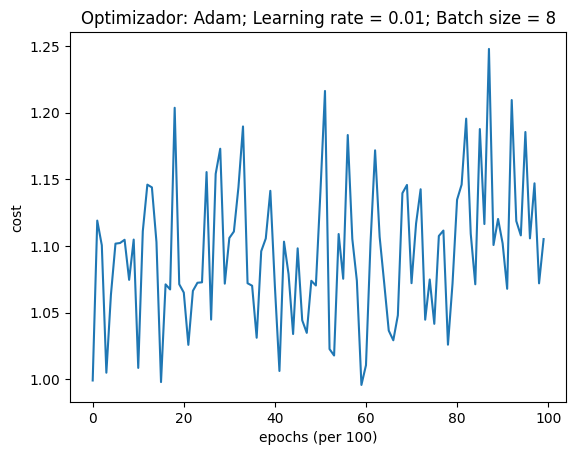

La exactitud para optimizador Adam con learning rate 0.01 y nº batches: 8 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.01    NºBATCHES: 16
Costo tras epoch 0: 1.006672
Costo tras epoch 1000: 0.000331
Costo tras epoch 2000: 0.000297
Costo tras epoch 3000: 0.000024
Costo tras epoch 4000: 0.000004
Costo tras epoch 5000: 0.000065
Costo tras epoch 6000: 0.000004
Costo tras epoch 7000: 0.000003
Costo tras epoch 8000: 0.000001
Costo tras epoch 9000: 0.000004


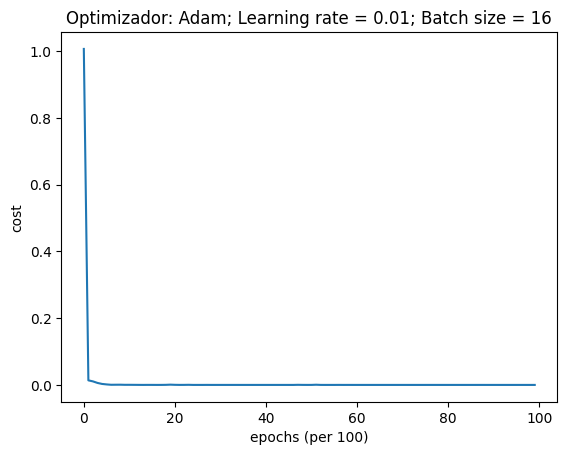

La exactitud para optimizador Adam con learning rate 0.01 y nº batches: 16 es de: 
95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.01    NºBATCHES: 32
Costo tras epoch 0: 1.238637
Costo tras epoch 1000: 1.105572
Costo tras epoch 2000: 1.059467
Costo tras epoch 3000: 1.041065
Costo tras epoch 4000: 1.119121
Costo tras epoch 5000: 1.106205
Costo tras epoch 6000: 1.110724
Costo tras epoch 7000: 1.090984
Costo tras epoch 8000: 1.083015
Costo tras epoch 9000: 1.111858


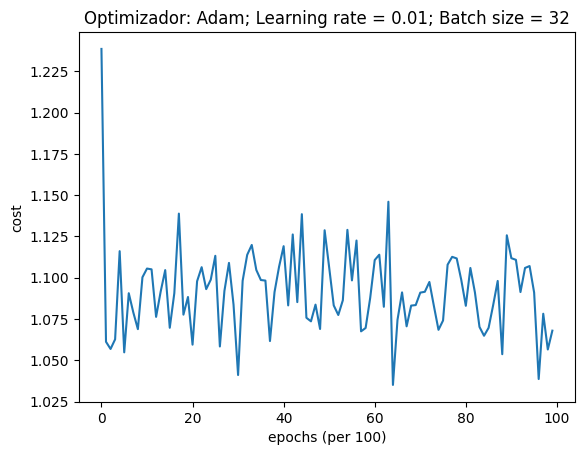

La exactitud para optimizador Adam con learning rate 0.01 y nº batches: 32 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.005    NºBATCHES: 8
Costo tras epoch 0: 1.125667
Costo tras epoch 1000: 0.000034
Costo tras epoch 2000: 0.000012
Costo tras epoch 3000: 0.000008
Costo tras epoch 4000: 0.000001
Costo tras epoch 5000: 0.000003
Costo tras epoch 6000: 0.000000
Costo tras epoch 7000: 0.000001
Costo tras epoch 8000: 0.000000
Costo tras epoch 9000: -0.000000


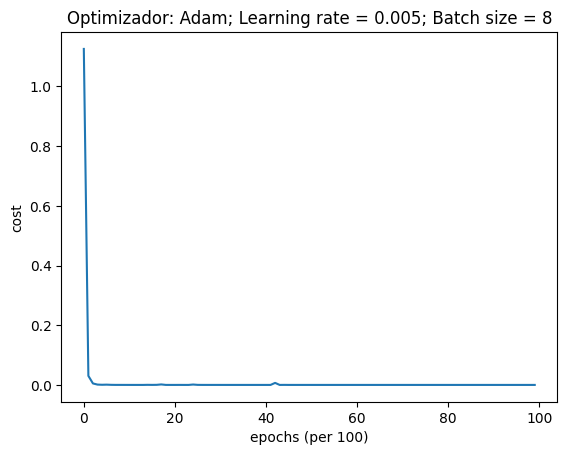

La exactitud para optimizador Adam con learning rate 0.005 y nº batches: 8 es de: 
95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.005    NºBATCHES: 16
Costo tras epoch 0: 1.052400
Costo tras epoch 1000: 1.114661
Costo tras epoch 2000: 1.110337
Costo tras epoch 3000: 1.039059
Costo tras epoch 4000: 1.040298
Costo tras epoch 5000: 1.057835
Costo tras epoch 6000: 1.184896
Costo tras epoch 7000: 1.122082
Costo tras epoch 8000: 1.073945
Costo tras epoch 9000: 1.182420


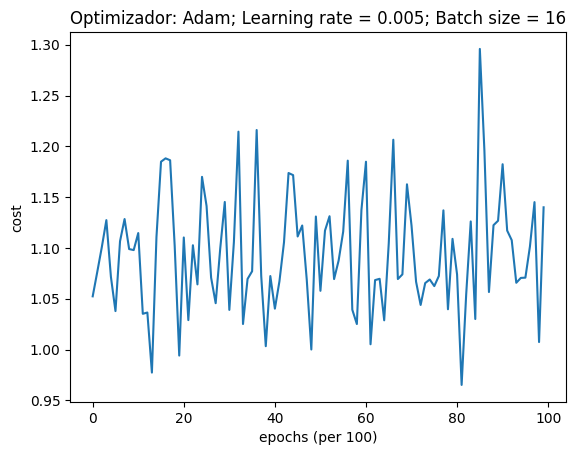

La exactitud para optimizador Adam con learning rate 0.005 y nº batches: 16 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.005    NºBATCHES: 32
Costo tras epoch 0: 1.112949
Costo tras epoch 1000: 0.000756
Costo tras epoch 2000: 0.000185
Costo tras epoch 3000: 0.000035
Costo tras epoch 4000: 0.000009
Costo tras epoch 5000: 0.000003
Costo tras epoch 6000: 0.000002
Costo tras epoch 7000: 0.000001
Costo tras epoch 8000: 0.000001
Costo tras epoch 9000: 0.000001


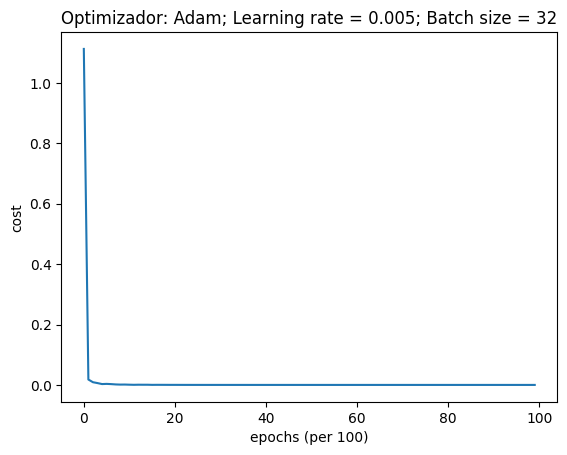

La exactitud para optimizador Adam con learning rate 0.005 y nº batches: 32 es de: 
95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.001    NºBATCHES: 8
Costo tras epoch 0: 1.049110
Costo tras epoch 1000: 1.142771
Costo tras epoch 2000: 1.143791
Costo tras epoch 3000: 1.066921
Costo tras epoch 4000: 1.110097
Costo tras epoch 5000: 1.031644
Costo tras epoch 6000: 1.066026
Costo tras epoch 7000: 1.181447
Costo tras epoch 8000: 1.110868
Costo tras epoch 9000: 0.997428


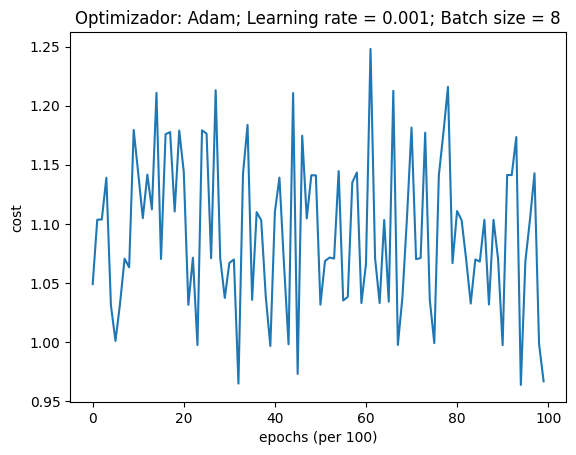

La exactitud para optimizador Adam con learning rate 0.001 y nº batches: 8 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.001    NºBATCHES: 16
Costo tras epoch 0: 1.110813
Costo tras epoch 1000: 0.000091
Costo tras epoch 2000: 0.000000
Costo tras epoch 3000: 0.000000
Costo tras epoch 4000: 0.000000
Costo tras epoch 5000: 0.000000
Costo tras epoch 6000: 0.000001
Costo tras epoch 7000: 0.000001
Costo tras epoch 8000: 0.000000
Costo tras epoch 9000: -0.000000


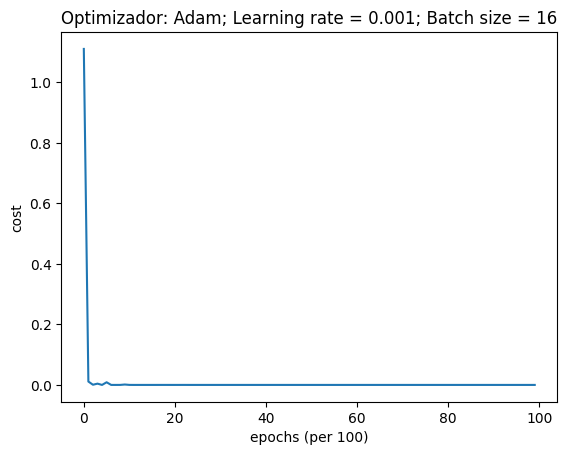

La exactitud para optimizador Adam con learning rate 0.001 y nº batches: 16 es de: 
95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.001    NºBATCHES: 32
Costo tras epoch 0: 1.104939
Costo tras epoch 1000: 0.000358
Costo tras epoch 2000: 0.000012
Costo tras epoch 3000: 0.000024
Costo tras epoch 4000: 0.000000
Costo tras epoch 5000: 0.000001
Costo tras epoch 6000: 0.000000
Costo tras epoch 7000: 0.000000
Costo tras epoch 8000: 0.000000
Costo tras epoch 9000: 0.000000


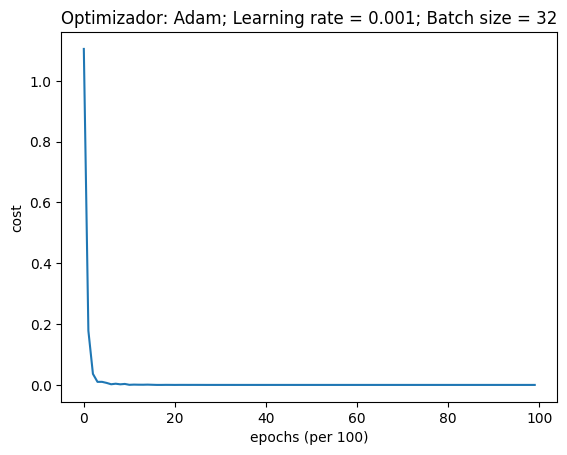

La exactitud para optimizador Adam con learning rate 0.001 y nº batches: 32 es de: 
95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0005    NºBATCHES: 8
Costo tras epoch 0: 1.088787
Costo tras epoch 1000: 0.008315
Costo tras epoch 2000: 0.000212
Costo tras epoch 3000: 0.000000
Costo tras epoch 4000: 0.000000
Costo tras epoch 5000: 0.000000
Costo tras epoch 6000: 0.000000
Costo tras epoch 7000: 0.000000
Costo tras epoch 8000: -0.000000
Costo tras epoch 9000: 0.000000


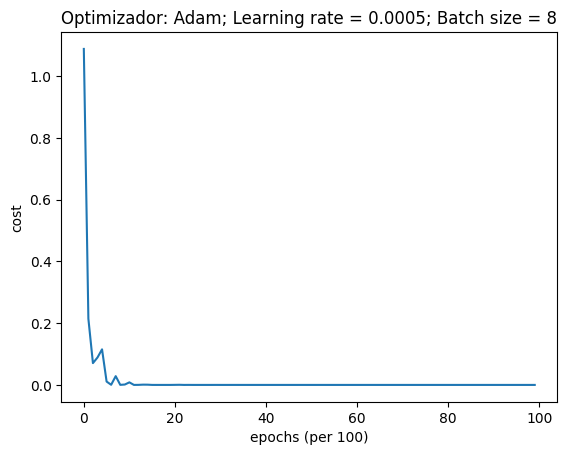

La exactitud para optimizador Adam con learning rate 0.0005 y nº batches: 8 es de: 
100.000000 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0005    NºBATCHES: 16
Costo tras epoch 0: 1.094570
Costo tras epoch 1000: 0.059636
Costo tras epoch 2000: 0.002821
Costo tras epoch 3000: 0.000142
Costo tras epoch 4000: 0.000022
Costo tras epoch 5000: 0.000015
Costo tras epoch 6000: 0.000004
Costo tras epoch 7000: -0.000000
Costo tras epoch 8000: 0.000006
Costo tras epoch 9000: 0.000007


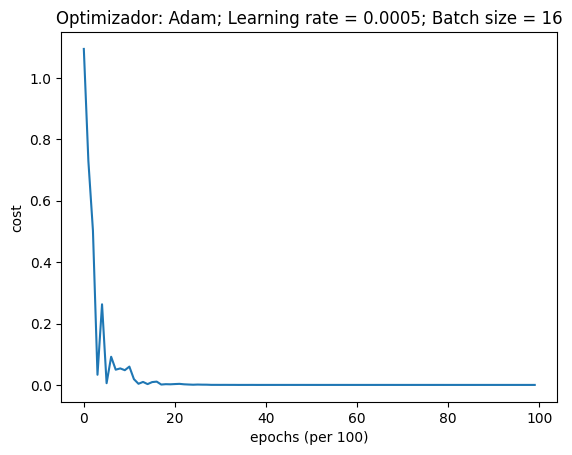

La exactitud para optimizador Adam con learning rate 0.0005 y nº batches: 16 es de: 
95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0005    NºBATCHES: 32
Costo tras epoch 0: 1.103413
Costo tras epoch 1000: 0.088619
Costo tras epoch 2000: 0.023726
Costo tras epoch 3000: 0.004314
Costo tras epoch 4000: 0.002384
Costo tras epoch 5000: 0.000433
Costo tras epoch 6000: 0.000164
Costo tras epoch 7000: 0.000046
Costo tras epoch 8000: 0.000041
Costo tras epoch 9000: 0.000014


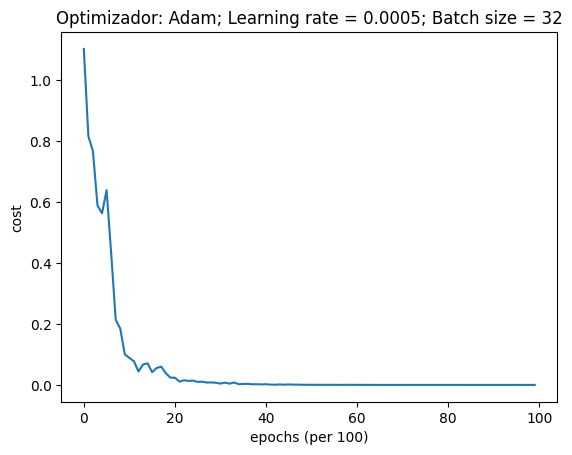

La exactitud para optimizador Adam con learning rate 0.0005 y nº batches: 32 es de: 
95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0001    NºBATCHES: 8
Costo tras epoch 0: 1.099332
Costo tras epoch 1000: 0.059175
Costo tras epoch 2000: 0.044492
Costo tras epoch 3000: 0.004858
Costo tras epoch 4000: 0.000033
Costo tras epoch 5000: 0.000000
Costo tras epoch 6000: 0.000001
Costo tras epoch 7000: 0.000009
Costo tras epoch 8000: 0.000000
Costo tras epoch 9000: 0.000003


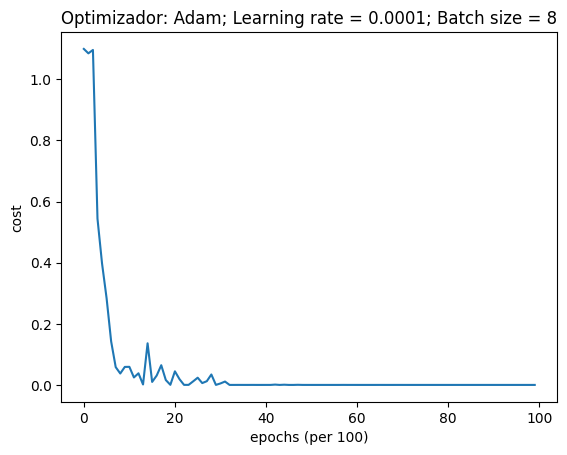

La exactitud para optimizador Adam con learning rate 0.0001 y nº batches: 8 es de: 
95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0001    NºBATCHES: 16
Costo tras epoch 0: 1.099565
Costo tras epoch 1000: 1.102421
Costo tras epoch 2000: 1.139283
Costo tras epoch 3000: 1.103855
Costo tras epoch 4000: 1.070562
Costo tras epoch 5000: 1.135065
Costo tras epoch 6000: 1.031188
Costo tras epoch 7000: 1.069926
Costo tras epoch 8000: 1.104421
Costo tras epoch 9000: 1.094950


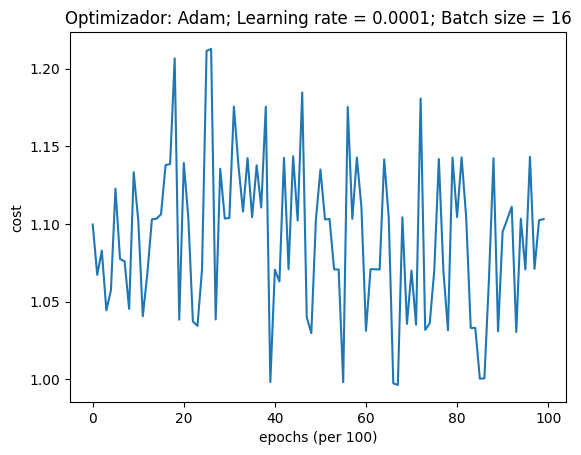

La exactitud para optimizador Adam con learning rate 0.0001 y nº batches: 16 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0001    NºBATCHES: 32
Costo tras epoch 0: 1.099173
Costo tras epoch 1000: 1.109652
Costo tras epoch 2000: 1.105104
Costo tras epoch 3000: 1.076337
Costo tras epoch 4000: 1.119479
Costo tras epoch 5000: 1.084873
Costo tras epoch 6000: 1.098132
Costo tras epoch 7000: 1.054850
Costo tras epoch 8000: 1.104696
Costo tras epoch 9000: 1.084823


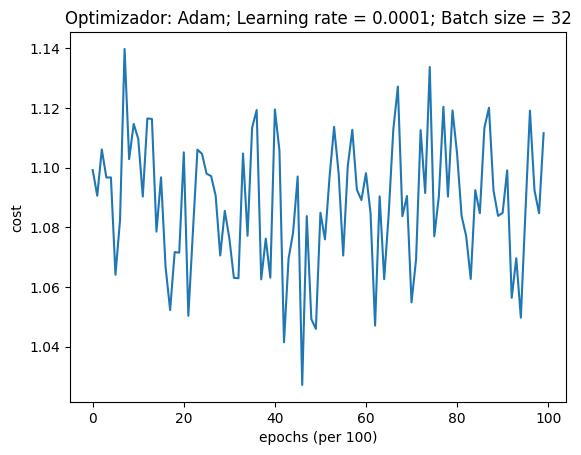

La exactitud para optimizador Adam con learning rate 0.0001 y nº batches: 32 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 5e-05    NºBATCHES: 8
Costo tras epoch 0: 1.098029
Costo tras epoch 1000: 1.077050
Costo tras epoch 2000: 1.038020
Costo tras epoch 3000: 1.209303
Costo tras epoch 4000: 1.032663
Costo tras epoch 5000: 1.138047
Costo tras epoch 6000: 1.070313
Costo tras epoch 7000: 1.213468
Costo tras epoch 8000: 1.103936
Costo tras epoch 9000: 1.070500


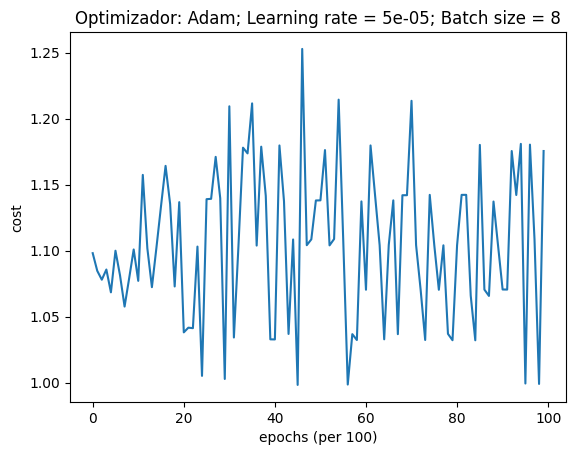

La exactitud para optimizador Adam con learning rate 5e-05 y nº batches: 8 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 5e-05    NºBATCHES: 16
Costo tras epoch 0: 1.098528
Costo tras epoch 1000: 1.078733
Costo tras epoch 2000: 1.102759
Costo tras epoch 3000: 1.072278
Costo tras epoch 4000: 1.067978
Costo tras epoch 5000: 1.070538
Costo tras epoch 6000: 1.175996
Costo tras epoch 7000: 1.141641
Costo tras epoch 8000: 0.997669
Costo tras epoch 9000: 0.998248


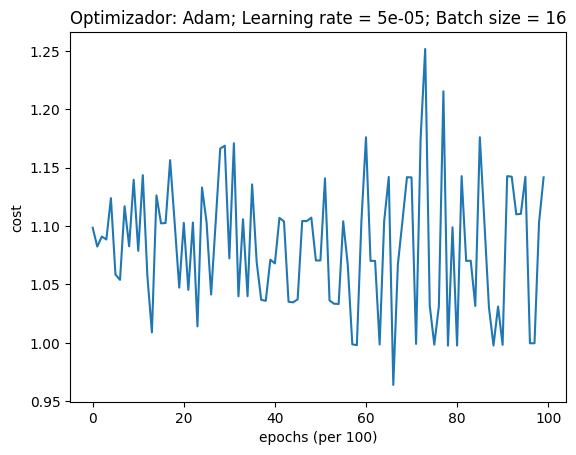

La exactitud para optimizador Adam con learning rate 5e-05 y nº batches: 16 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 5e-05    NºBATCHES: 32
Costo tras epoch 0: 1.098454
Costo tras epoch 1000: 1.050610
Costo tras epoch 2000: 0.808543
Costo tras epoch 3000: 0.101389
Costo tras epoch 4000: 0.085443
Costo tras epoch 5000: 0.015145
Costo tras epoch 6000: 0.036715
Costo tras epoch 7000: 0.027525
Costo tras epoch 8000: 0.005605
Costo tras epoch 9000: 0.001926


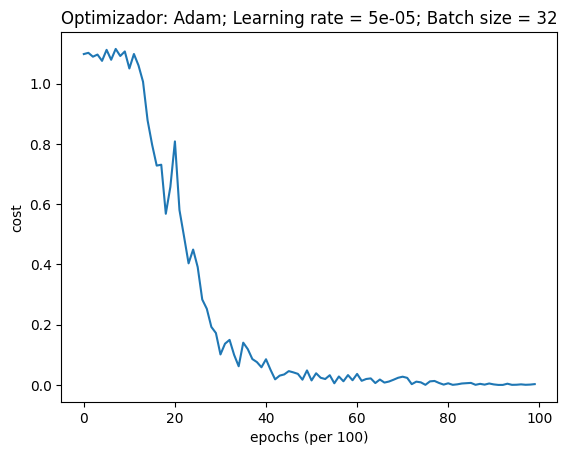

La exactitud para optimizador Adam con learning rate 5e-05 y nº batches: 32 es de: 
95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 1e-05    NºBATCHES: 8
Costo tras epoch 0: 1.099109
Costo tras epoch 1000: 1.082573
Costo tras epoch 2000: 1.127065
Costo tras epoch 3000: 0.854029
Costo tras epoch 4000: 0.404707
Costo tras epoch 5000: 0.427502
Costo tras epoch 6000: 0.162370
Costo tras epoch 7000: 0.035414
Costo tras epoch 8000: 0.037660
Costo tras epoch 9000: 0.030838


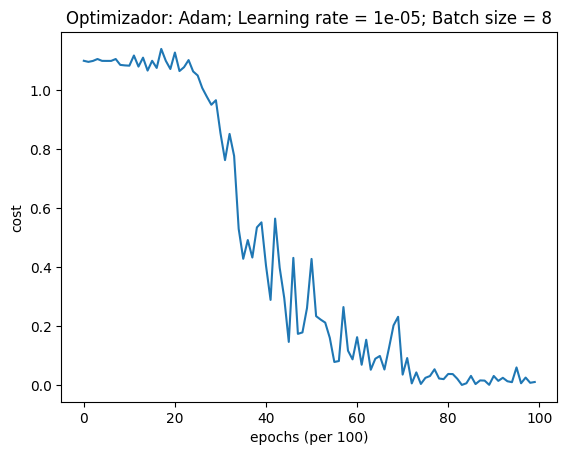

La exactitud para optimizador Adam con learning rate 1e-05 y nº batches: 8 es de: 
95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 1e-05    NºBATCHES: 16
Costo tras epoch 0: 1.098292
Costo tras epoch 1000: 1.086559
Costo tras epoch 2000: 1.084015
Costo tras epoch 3000: 0.971963
Costo tras epoch 4000: 0.685609
Costo tras epoch 5000: 0.675686
Costo tras epoch 6000: 0.314244
Costo tras epoch 7000: 0.290697
Costo tras epoch 8000: 0.204185
Costo tras epoch 9000: 0.066052


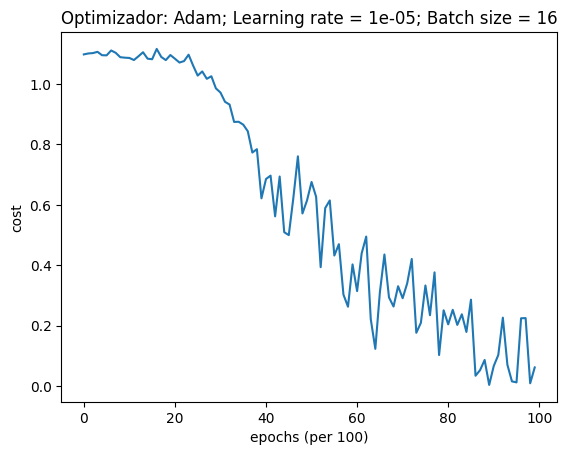

La exactitud para optimizador Adam con learning rate 1e-05 y nº batches: 16 es de: 
95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 1e-05    NºBATCHES: 32
Costo tras epoch 0: 1.098576
Costo tras epoch 1000: 1.097506
Costo tras epoch 2000: 1.086174
Costo tras epoch 3000: 1.082687
Costo tras epoch 4000: 1.082097
Costo tras epoch 5000: 1.018494
Costo tras epoch 6000: 0.921405
Costo tras epoch 7000: 0.800170
Costo tras epoch 8000: 0.748781
Costo tras epoch 9000: 0.662549


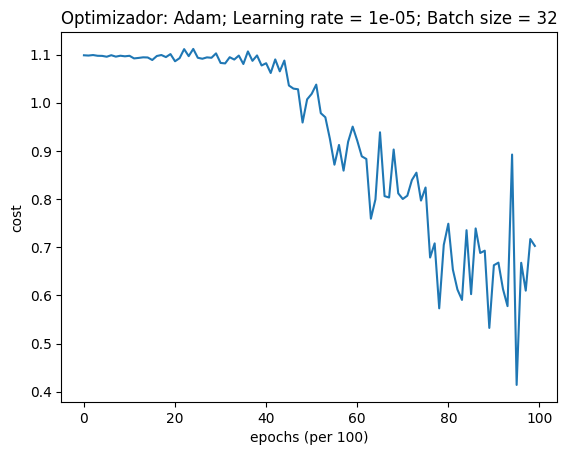

La exactitud para optimizador Adam con learning rate 1e-05 y nº batches: 32 es de: 
66.666667 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.5    NºBATCHES: 8
Costo tras epoch 0: 1.118043
Costo tras epoch 1000: 1.089468
Costo tras epoch 2000: 1.169654
Costo tras epoch 3000: 0.988967
Costo tras epoch 4000: 1.072539
Costo tras epoch 5000: 1.114064
Costo tras epoch 6000: 1.167520
Costo tras epoch 7000: 1.044034
Costo tras epoch 8000: 1.058618
Costo tras epoch 9000: 1.065148


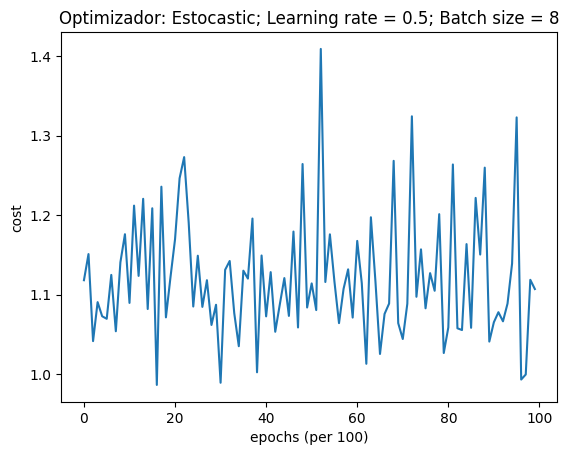

La exactitud para optimizador Estocastic con learning rate 0.5 y nº batches: 8 es de: 
19.047619 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.5    NºBATCHES: 16
Costo tras epoch 0: 1.187516
Costo tras epoch 1000: 1.152780
Costo tras epoch 2000: 1.012359
Costo tras epoch 3000: 1.038772
Costo tras epoch 4000: 1.080655
Costo tras epoch 5000: 1.152480
Costo tras epoch 6000: 1.179327
Costo tras epoch 7000: 1.194602
Costo tras epoch 8000: 1.237162
Costo tras epoch 9000: 1.077600


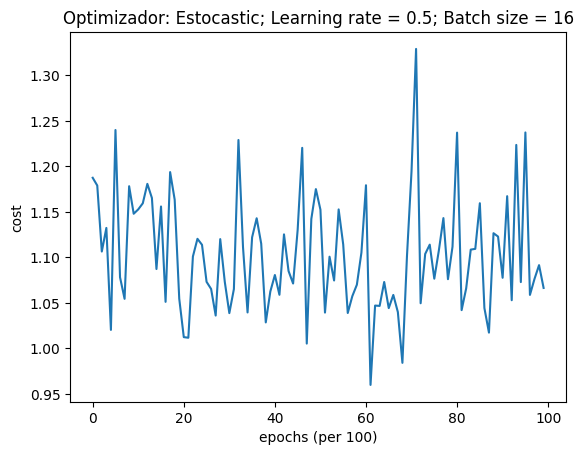

La exactitud para optimizador Estocastic con learning rate 0.5 y nº batches: 16 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.5    NºBATCHES: 32
Costo tras epoch 0: 1.095112
Costo tras epoch 1000: 1.106598
Costo tras epoch 2000: 1.092942
Costo tras epoch 3000: 1.103251
Costo tras epoch 4000: 1.065156
Costo tras epoch 5000: 1.061753
Costo tras epoch 6000: 1.127788
Costo tras epoch 7000: 1.084659
Costo tras epoch 8000: 1.092824
Costo tras epoch 9000: 1.073449


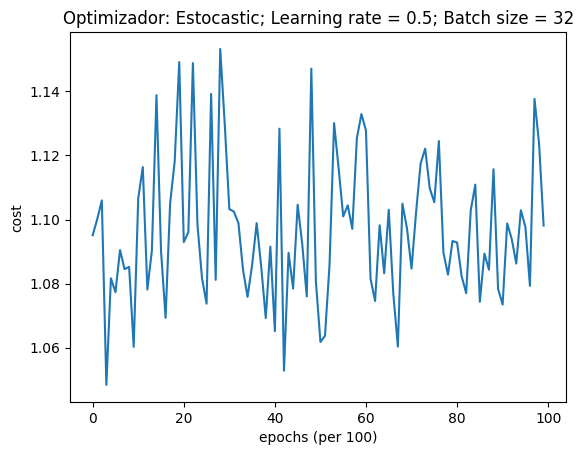

La exactitud para optimizador Estocastic con learning rate 0.5 y nº batches: 32 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.1    NºBATCHES: 8
Costo tras epoch 0: 1.101025
Costo tras epoch 1000: 1.129524
Costo tras epoch 2000: 1.212533
Costo tras epoch 3000: 1.104618
Costo tras epoch 4000: 1.072094
Costo tras epoch 5000: 1.115064
Costo tras epoch 6000: 1.144433
Costo tras epoch 7000: 1.066229
Costo tras epoch 8000: 1.083385
Costo tras epoch 9000: 1.145028


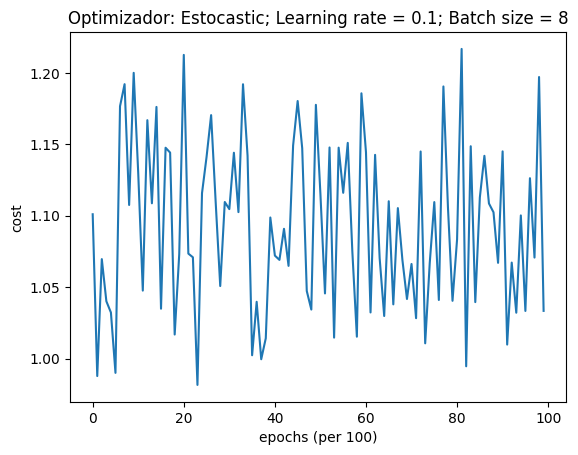

La exactitud para optimizador Estocastic con learning rate 0.1 y nº batches: 8 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.1    NºBATCHES: 16
Costo tras epoch 0: 1.100224
Costo tras epoch 1000: 1.103823
Costo tras epoch 2000: 1.132695
Costo tras epoch 3000: 1.041016
Costo tras epoch 4000: 1.121216
Costo tras epoch 5000: 1.006259
Costo tras epoch 6000: 1.027971
Costo tras epoch 7000: 1.051450
Costo tras epoch 8000: 1.105571
Costo tras epoch 9000: 1.040706


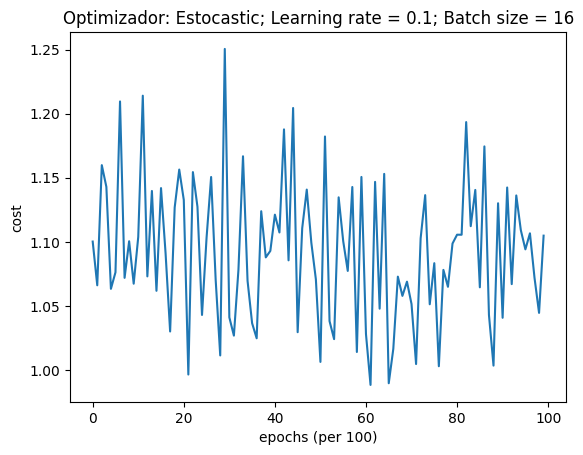

La exactitud para optimizador Estocastic con learning rate 0.1 y nº batches: 16 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.1    NºBATCHES: 32
Costo tras epoch 0: 1.097484
Costo tras epoch 1000: 1.045739
Costo tras epoch 2000: 1.072686
Costo tras epoch 3000: 1.091721
Costo tras epoch 4000: 1.083375
Costo tras epoch 5000: 1.091946
Costo tras epoch 6000: 1.085228
Costo tras epoch 7000: 1.105705
Costo tras epoch 8000: 1.083372
Costo tras epoch 9000: 1.112652


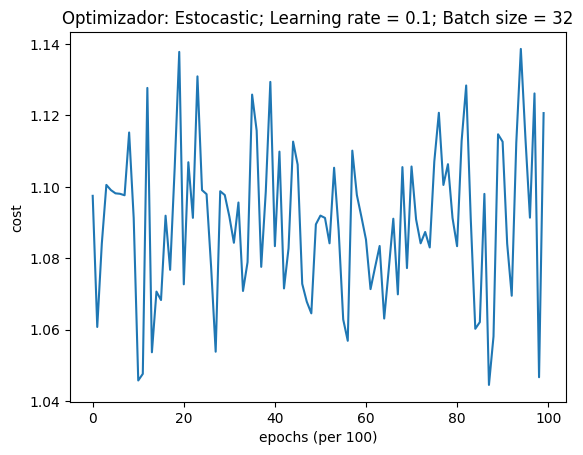

La exactitud para optimizador Estocastic con learning rate 0.1 y nº batches: 32 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.05    NºBATCHES: 8
Costo tras epoch 0: 1.114588
Costo tras epoch 1000: 1.112056
Costo tras epoch 2000: 1.139534
Costo tras epoch 3000: 1.140400
Costo tras epoch 4000: 1.005151
Costo tras epoch 5000: 1.029807
Costo tras epoch 6000: 1.140510
Costo tras epoch 7000: 0.499493
Costo tras epoch 8000: 0.006575
Costo tras epoch 9000: 0.001250


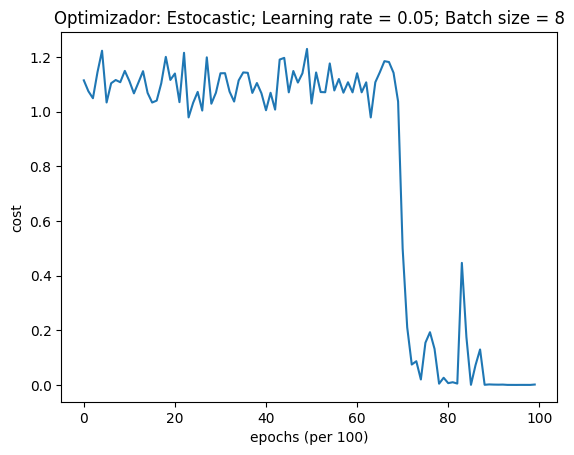

La exactitud para optimizador Estocastic con learning rate 0.05 y nº batches: 8 es de: 
95.238095 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.05    NºBATCHES: 16
Costo tras epoch 0: 1.099153
Costo tras epoch 1000: 0.992036
Costo tras epoch 2000: 1.103812
Costo tras epoch 3000: 1.041733
Costo tras epoch 4000: 1.228393
Costo tras epoch 5000: 1.096048
Costo tras epoch 6000: 1.091532
Costo tras epoch 7000: 1.051711
Costo tras epoch 8000: 1.095853
Costo tras epoch 9000: 1.069730


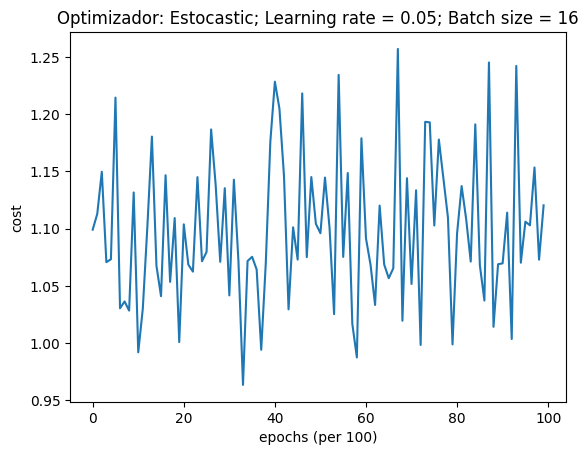

La exactitud para optimizador Estocastic con learning rate 0.05 y nº batches: 16 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.05    NºBATCHES: 32
Costo tras epoch 0: 1.098992
Costo tras epoch 1000: 1.076478
Costo tras epoch 2000: 1.070018
Costo tras epoch 3000: 1.093523
Costo tras epoch 4000: 1.129520
Costo tras epoch 5000: 1.075833
Costo tras epoch 6000: 1.111330
Costo tras epoch 7000: 1.044528
Costo tras epoch 8000: 1.097041
Costo tras epoch 9000: 1.150714


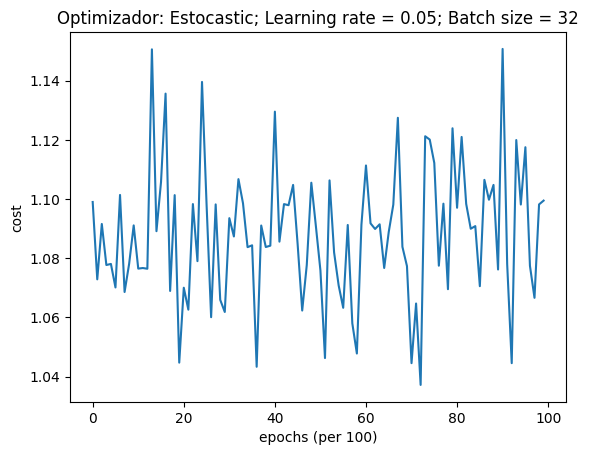

La exactitud para optimizador Estocastic con learning rate 0.05 y nº batches: 32 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.01    NºBATCHES: 8
Costo tras epoch 0: 1.097595
Costo tras epoch 1000: 1.143675
Costo tras epoch 2000: 1.070747
Costo tras epoch 3000: 1.103046
Costo tras epoch 4000: 1.070403
Costo tras epoch 5000: 1.141842
Costo tras epoch 6000: 1.101855
Costo tras epoch 7000: 1.035324
Costo tras epoch 8000: 1.103148
Costo tras epoch 9000: 1.139719


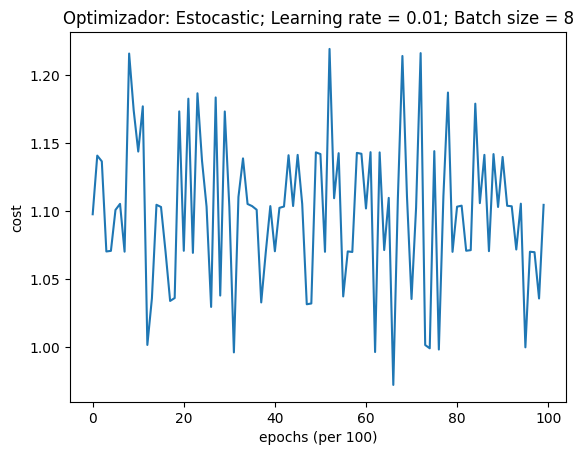

La exactitud para optimizador Estocastic con learning rate 0.01 y nº batches: 8 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.01    NºBATCHES: 16
Costo tras epoch 0: 1.097474
Costo tras epoch 1000: 1.103915
Costo tras epoch 2000: 1.028016
Costo tras epoch 3000: 1.104736
Costo tras epoch 4000: 1.036125
Costo tras epoch 5000: 1.104289
Costo tras epoch 6000: 0.999494
Costo tras epoch 7000: 0.993789
Costo tras epoch 8000: 1.102574
Costo tras epoch 9000: 1.071032


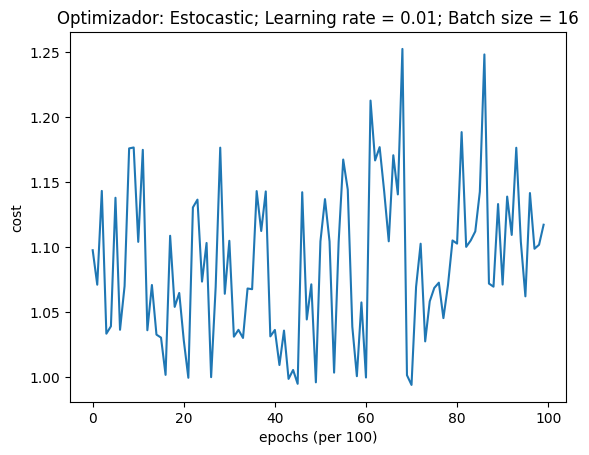

La exactitud para optimizador Estocastic con learning rate 0.01 y nº batches: 16 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.01    NºBATCHES: 32
Costo tras epoch 0: 1.098561
Costo tras epoch 1000: 1.077049
Costo tras epoch 2000: 1.097508
Costo tras epoch 3000: 1.099130
Costo tras epoch 4000: 1.098052
Costo tras epoch 5000: 1.077560
Costo tras epoch 6000: 1.084651
Costo tras epoch 7000: 1.105032
Costo tras epoch 8000: 1.069517
Costo tras epoch 9000: 1.098155


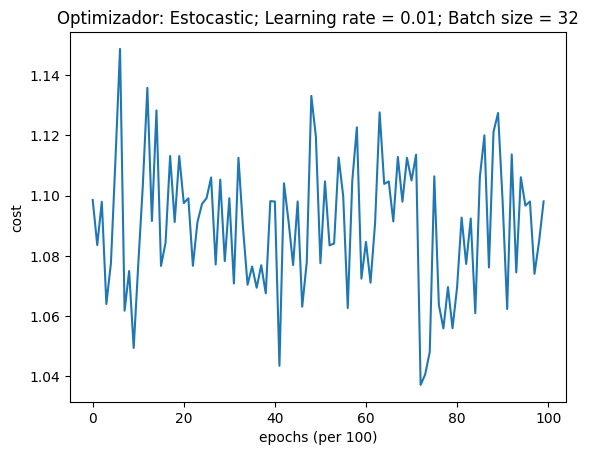

La exactitud para optimizador Estocastic con learning rate 0.01 y nº batches: 32 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.005    NºBATCHES: 8
Costo tras epoch 0: 1.101211
Costo tras epoch 1000: 1.177115
Costo tras epoch 2000: 1.032464
Costo tras epoch 3000: 1.069876
Costo tras epoch 4000: 0.999949
Costo tras epoch 5000: 1.039145
Costo tras epoch 6000: 1.093043
Costo tras epoch 7000: 0.995234
Costo tras epoch 8000: 0.997336
Costo tras epoch 9000: 1.032513


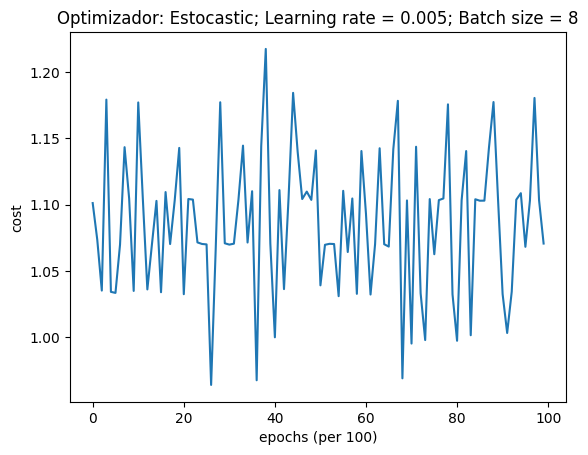

La exactitud para optimizador Estocastic con learning rate 0.005 y nº batches: 8 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.005    NºBATCHES: 16
Costo tras epoch 0: 1.098353
Costo tras epoch 1000: 1.067314
Costo tras epoch 2000: 1.063999
Costo tras epoch 3000: 1.071534
Costo tras epoch 4000: 1.033037
Costo tras epoch 5000: 1.037290
Costo tras epoch 6000: 1.069075
Costo tras epoch 7000: 1.066718
Costo tras epoch 8000: 1.031808
Costo tras epoch 9000: 1.108644


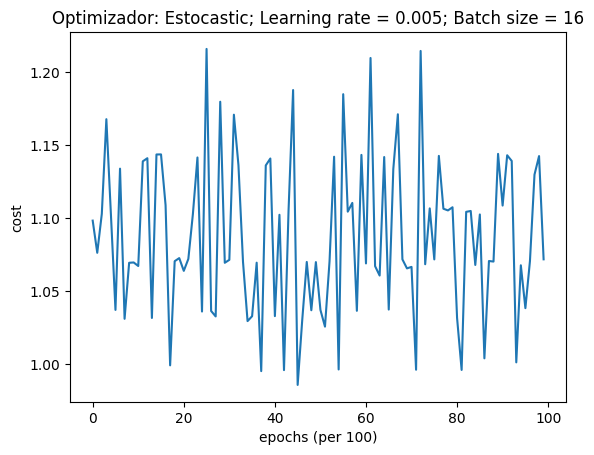

La exactitud para optimizador Estocastic con learning rate 0.005 y nº batches: 16 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.005    NºBATCHES: 32
Costo tras epoch 0: 1.098586
Costo tras epoch 1000: 1.134967
Costo tras epoch 2000: 1.134086
Costo tras epoch 3000: 1.076871
Costo tras epoch 4000: 1.098173
Costo tras epoch 5000: 1.083612
Costo tras epoch 6000: 1.156147
Costo tras epoch 7000: 1.076124
Costo tras epoch 8000: 1.070580
Costo tras epoch 9000: 1.084545


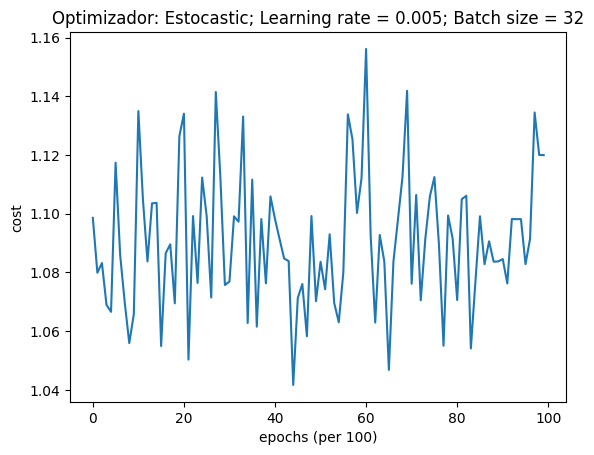

La exactitud para optimizador Estocastic con learning rate 0.005 y nº batches: 32 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.001    NºBATCHES: 8
Costo tras epoch 0: 1.098758
Costo tras epoch 1000: 1.103420
Costo tras epoch 2000: 1.136733
Costo tras epoch 3000: 1.142373
Costo tras epoch 4000: 0.998973
Costo tras epoch 5000: 1.103802
Costo tras epoch 6000: 0.964879
Costo tras epoch 7000: 0.999067
Costo tras epoch 8000: 0.998754
Costo tras epoch 9000: 1.214978


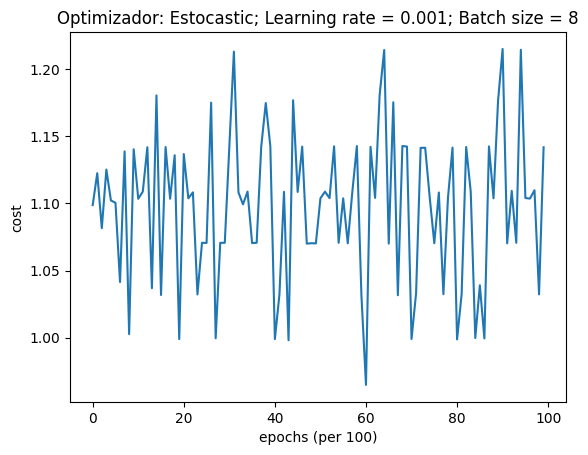

La exactitud para optimizador Estocastic con learning rate 0.001 y nº batches: 8 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.001    NºBATCHES: 16
Costo tras epoch 0: 1.098560
Costo tras epoch 1000: 1.100384
Costo tras epoch 2000: 1.136229
Costo tras epoch 3000: 1.103866
Costo tras epoch 4000: 1.175509
Costo tras epoch 5000: 0.964836
Costo tras epoch 6000: 1.103550
Costo tras epoch 7000: 1.071465
Costo tras epoch 8000: 1.255165
Costo tras epoch 9000: 1.070324


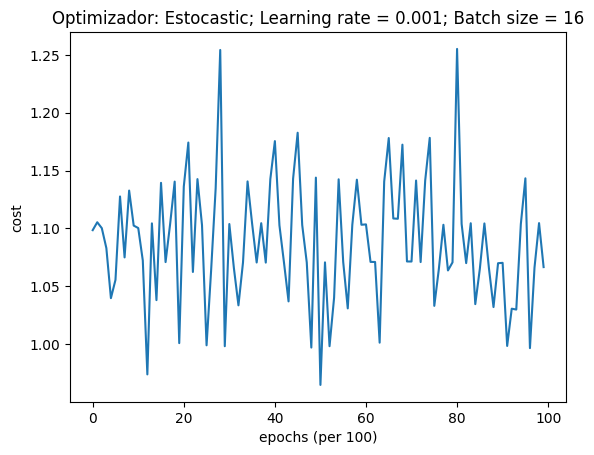

La exactitud para optimizador Estocastic con learning rate 0.001 y nº batches: 16 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.001    NºBATCHES: 32
Costo tras epoch 0: 1.098607
Costo tras epoch 1000: 1.073873
Costo tras epoch 2000: 1.103418
Costo tras epoch 3000: 1.083405
Costo tras epoch 4000: 1.061232
Costo tras epoch 5000: 1.084721
Costo tras epoch 6000: 1.083731
Costo tras epoch 7000: 1.114566
Costo tras epoch 8000: 1.049280
Costo tras epoch 9000: 1.120201


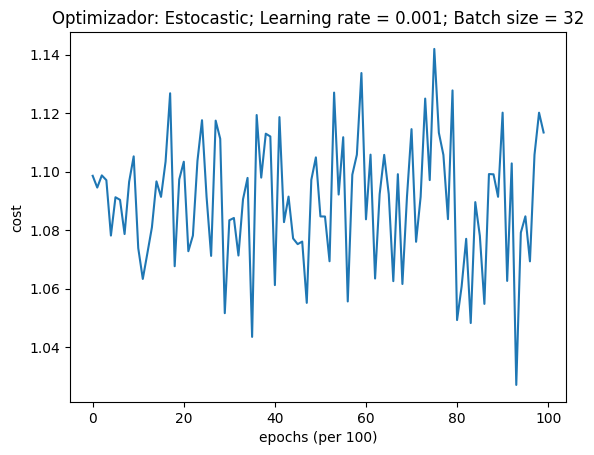

La exactitud para optimizador Estocastic con learning rate 0.001 y nº batches: 32 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0005    NºBATCHES: 8
Costo tras epoch 0: 1.098560
Costo tras epoch 1000: 1.044954
Costo tras epoch 2000: 1.001070
Costo tras epoch 3000: 1.103887
Costo tras epoch 4000: 1.070338
Costo tras epoch 5000: 1.142390
Costo tras epoch 6000: 0.966525
Costo tras epoch 7000: 1.141723
Costo tras epoch 8000: 0.998025
Costo tras epoch 9000: 1.137429


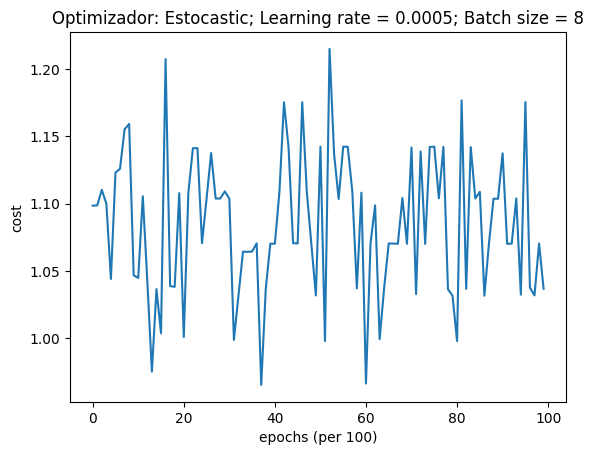

La exactitud para optimizador Estocastic con learning rate 0.0005 y nº batches: 8 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0005    NºBATCHES: 16
Costo tras epoch 0: 1.098585
Costo tras epoch 1000: 1.057701
Costo tras epoch 2000: 1.042564
Costo tras epoch 3000: 1.138624
Costo tras epoch 4000: 1.104848
Costo tras epoch 5000: 1.103455
Costo tras epoch 6000: 1.181472
Costo tras epoch 7000: 1.103661
Costo tras epoch 8000: 0.964835
Costo tras epoch 9000: 1.065729


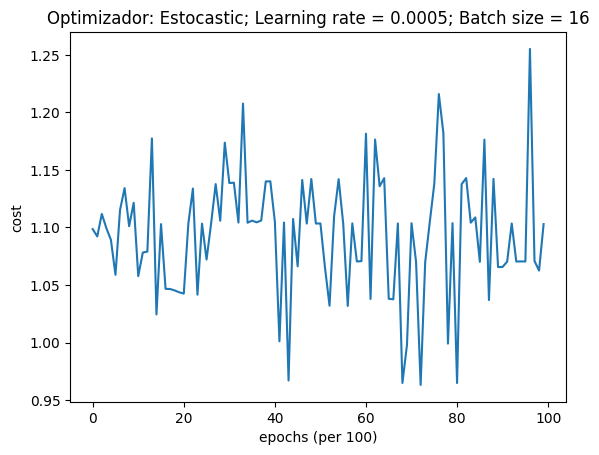

La exactitud para optimizador Estocastic con learning rate 0.0005 y nº batches: 16 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0005    NºBATCHES: 32
Costo tras epoch 0: 1.098610
Costo tras epoch 1000: 1.094026
Costo tras epoch 2000: 1.092338
Costo tras epoch 3000: 1.113659
Costo tras epoch 4000: 1.091950
Costo tras epoch 5000: 1.104533
Costo tras epoch 6000: 1.103611
Costo tras epoch 7000: 1.090669
Costo tras epoch 8000: 1.083962
Costo tras epoch 9000: 1.063808


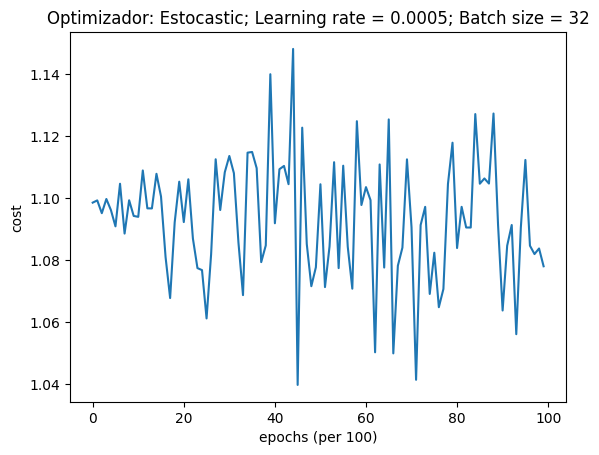

La exactitud para optimizador Estocastic con learning rate 0.0005 y nº batches: 32 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0001    NºBATCHES: 8
Costo tras epoch 0: 1.098590
Costo tras epoch 1000: 1.110220
Costo tras epoch 2000: 1.119114
Costo tras epoch 3000: 1.054635
Costo tras epoch 4000: 1.158808
Costo tras epoch 5000: 1.105073
Costo tras epoch 6000: 1.166732
Costo tras epoch 7000: 1.137992
Costo tras epoch 8000: 1.035831
Costo tras epoch 9000: 1.100309


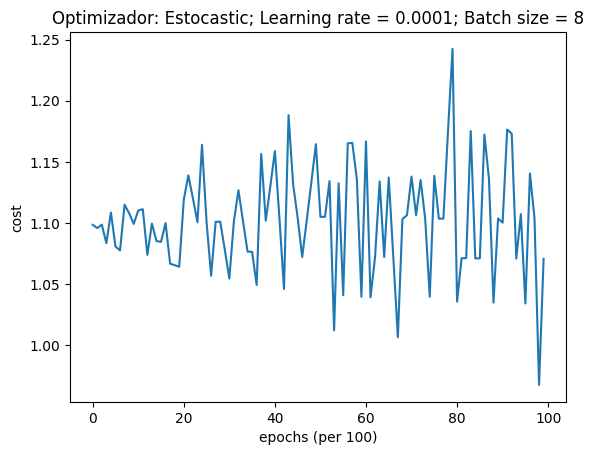

La exactitud para optimizador Estocastic con learning rate 0.0001 y nº batches: 8 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0001    NºBATCHES: 16
Costo tras epoch 0: 1.098620
Costo tras epoch 1000: 1.085629
Costo tras epoch 2000: 1.099162
Costo tras epoch 3000: 1.099819
Costo tras epoch 4000: 1.100986
Costo tras epoch 5000: 1.123443
Costo tras epoch 6000: 1.051806
Costo tras epoch 7000: 1.021499
Costo tras epoch 8000: 1.160107
Costo tras epoch 9000: 1.073866


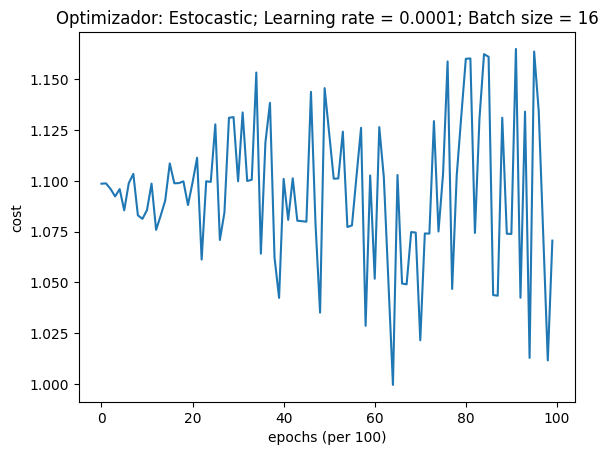

La exactitud para optimizador Estocastic con learning rate 0.0001 y nº batches: 16 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0001    NºBATCHES: 32
Costo tras epoch 0: 1.098613
Costo tras epoch 1000: 1.096660
Costo tras epoch 2000: 1.101410
Costo tras epoch 3000: 1.101018
Costo tras epoch 4000: 1.089909
Costo tras epoch 5000: 1.096903
Costo tras epoch 6000: 1.100036
Costo tras epoch 7000: 1.125730
Costo tras epoch 8000: 1.080801
Costo tras epoch 9000: 1.075654


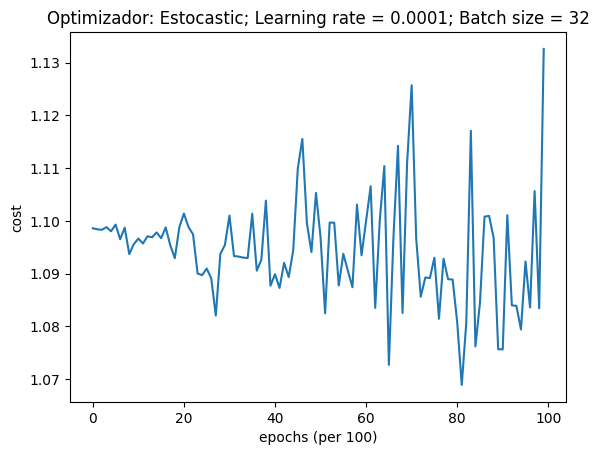

La exactitud para optimizador Estocastic con learning rate 0.0001 y nº batches: 32 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 5e-05    NºBATCHES: 8
Costo tras epoch 0: 1.098607
Costo tras epoch 1000: 1.098870
Costo tras epoch 2000: 1.088163
Costo tras epoch 3000: 1.069485
Costo tras epoch 4000: 1.119102
Costo tras epoch 5000: 1.100865
Costo tras epoch 6000: 1.030202
Costo tras epoch 7000: 1.050104
Costo tras epoch 8000: 1.075325
Costo tras epoch 9000: 1.074405


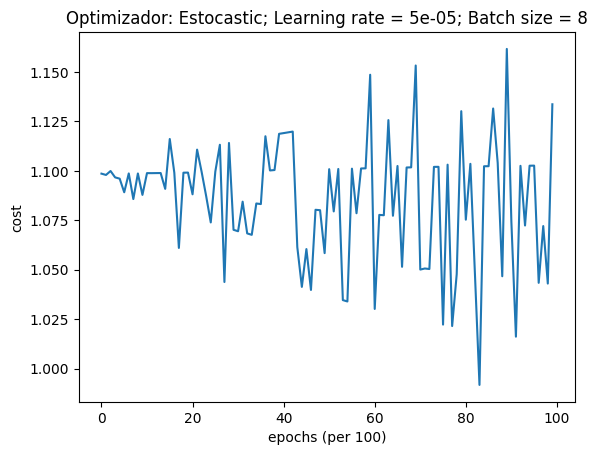

La exactitud para optimizador Estocastic con learning rate 5e-05 y nº batches: 8 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 5e-05    NºBATCHES: 16
Costo tras epoch 0: 1.098609
Costo tras epoch 1000: 1.095278
Costo tras epoch 2000: 1.092456
Costo tras epoch 3000: 1.089878
Costo tras epoch 4000: 1.075904
Costo tras epoch 5000: 1.113768
Costo tras epoch 6000: 1.099756
Costo tras epoch 7000: 1.118328
Costo tras epoch 8000: 1.061935
Costo tras epoch 9000: 1.100750


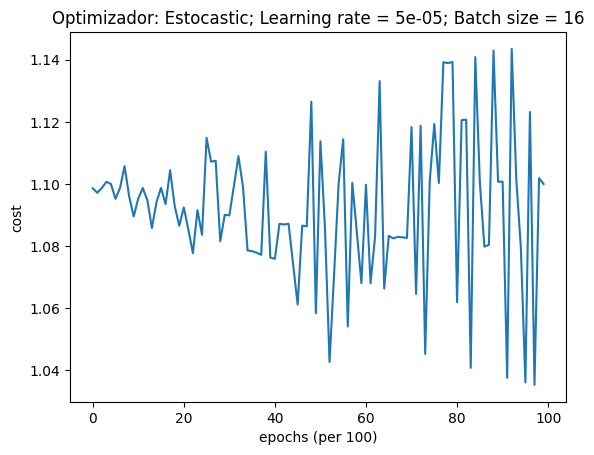

La exactitud para optimizador Estocastic con learning rate 5e-05 y nº batches: 16 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 5e-05    NºBATCHES: 32
Costo tras epoch 0: 1.098612
Costo tras epoch 1000: 1.099327
Costo tras epoch 2000: 1.094596
Costo tras epoch 3000: 1.094767
Costo tras epoch 4000: 1.104007
Costo tras epoch 5000: 1.092625
Costo tras epoch 6000: 1.089841
Costo tras epoch 7000: 1.084472
Costo tras epoch 8000: 1.092318
Costo tras epoch 9000: 1.102054


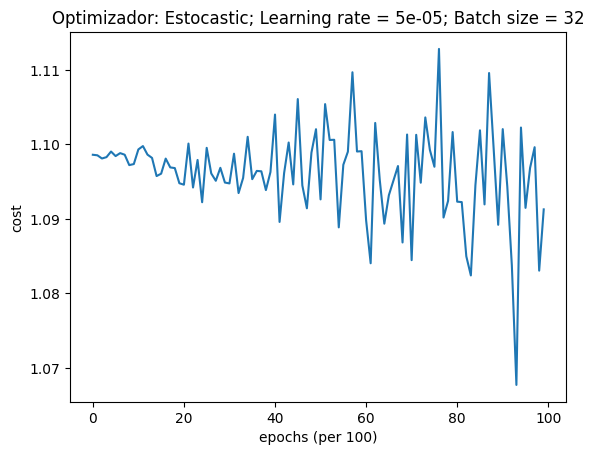

La exactitud para optimizador Estocastic con learning rate 5e-05 y nº batches: 32 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 1e-05    NºBATCHES: 8
Costo tras epoch 0: 1.098612
Costo tras epoch 1000: 1.094756
Costo tras epoch 2000: 1.088484
Costo tras epoch 3000: 1.102427
Costo tras epoch 4000: 1.108619
Costo tras epoch 5000: 1.080791
Costo tras epoch 6000: 1.105894
Costo tras epoch 7000: 1.090797
Costo tras epoch 8000: 1.071743
Costo tras epoch 9000: 1.099124


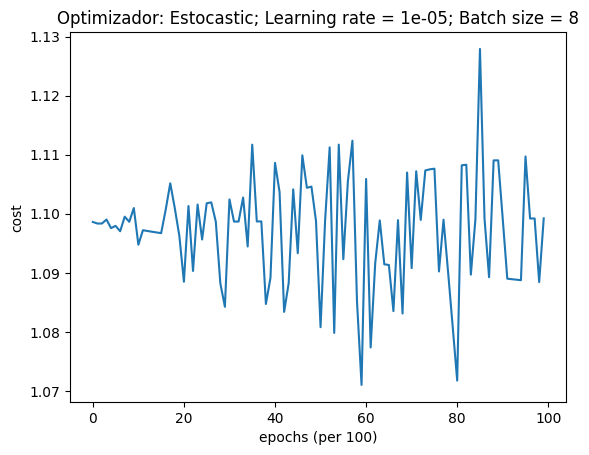

La exactitud para optimizador Estocastic con learning rate 1e-05 y nº batches: 8 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 1e-05    NºBATCHES: 16
Costo tras epoch 0: 1.098612
Costo tras epoch 1000: 1.097925
Costo tras epoch 2000: 1.097226
Costo tras epoch 3000: 1.102785
Costo tras epoch 4000: 1.104177
Costo tras epoch 5000: 1.098664
Costo tras epoch 6000: 1.102754
Costo tras epoch 7000: 1.098697
Costo tras epoch 8000: 1.088214
Costo tras epoch 9000: 1.104682


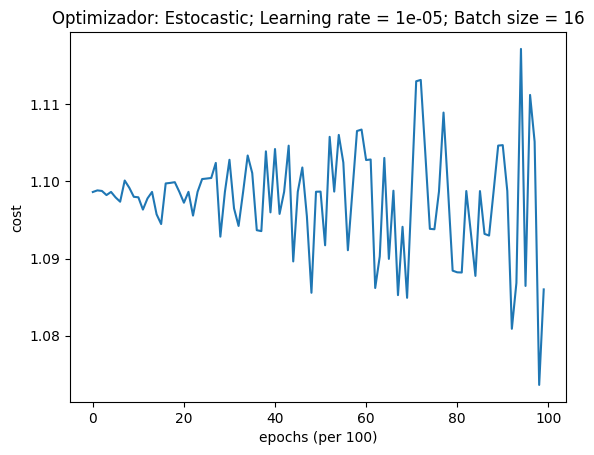

La exactitud para optimizador Estocastic con learning rate 1e-05 y nº batches: 16 es de: 
47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 1e-05    NºBATCHES: 32
Costo tras epoch 0: 1.098612
Costo tras epoch 1000: 1.098476
Costo tras epoch 2000: 1.098332
Costo tras epoch 3000: 1.098406
Costo tras epoch 4000: 1.096375
Costo tras epoch 5000: 1.096883
Costo tras epoch 6000: 1.096552
Costo tras epoch 7000: 1.097677
Costo tras epoch 8000: 1.100301
Costo tras epoch 9000: 1.096200


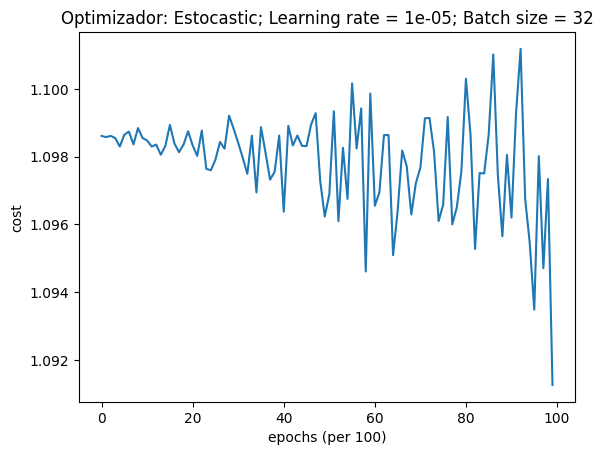

La exactitud para optimizador Estocastic con learning rate 1e-05 y nº batches: 32 es de: 
47.619048 %
------------------------



In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=156477)
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=15477)

layers_dims = [X.shape[1], 16, 12, 8, 3]  # Cualquier número de capas y neuronas
learning_rates = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
batches = [8, 16, 32]
optimizers = ['Adam', 'Estocastic']

resultados = {}

for optimizer in optimizers:
    for learning_rate in learning_rates:
        for batch in batches:
            print(f'------------------------\n')
            print(f'OPTIMIZADOR: {optimizer}    LEARNING_RATE: {learning_rate}    NºBATCHES: {batch}')
            parameters = model(X_train_2, y_train_2, layers_dims, optimizer_use=optimizer, learning_rate=learning_rate, num_epochs=10000, batch_size=batch)
            predictions, accuracy = predict(X_val, parameters, y_val)
            resultados[(optimizer, learning_rate, batch)] = accuracy
            print(f'La exactitud para optimizador {optimizer} con learning rate {learning_rate} y nº batches: {batch} es de: \n{accuracy*100:.6f} %')
            print(f'------------------------\n')


In [79]:
claves_ordenadas = sorted(resultados.keys(), key=lambda k: resultados[k], reverse=True)

# Imprimir las claves ordenadas
print("Claves ordenadas según el tamaño del valor:")
for clave in claves_ordenadas:
    print(f"{clave}: {resultados[clave]:.4f}")

Claves ordenadas según el tamaño del valor:
('Adam', 0.001, 16): 0.9524
('Adam', 0.001, 32): 0.9524
('Adam', 0.0005, 16): 0.9524
('Adam', 0.0005, 32): 0.9524
('Adam', 0.0001, 8): 0.9524
('Adam', 0.0001, 16): 0.9524
('Adam', 0.0001, 32): 0.9524
('Adam', 5e-05, 8): 0.9524
('Adam', 5e-05, 16): 0.9524
('Adam', 1e-05, 8): 0.9524
('Estocastic', 0.01, 8): 0.9524
('Adam', 0.01, 8): 0.6667
('Adam', 1e-05, 16): 0.6667
('Estocastic', 0.1, 32): 0.6667
('Estocastic', 0.05, 16): 0.5238
('Adam', 0.5, 8): 0.4762
('Adam', 0.5, 32): 0.4762
('Adam', 0.1, 8): 0.4762
('Adam', 0.1, 16): 0.4762
('Adam', 0.1, 32): 0.4762
('Adam', 0.05, 8): 0.4762
('Adam', 0.05, 16): 0.4762
('Adam', 0.05, 32): 0.4762
('Adam', 0.01, 16): 0.4762
('Adam', 0.01, 32): 0.4762
('Adam', 0.005, 8): 0.4762
('Adam', 0.005, 16): 0.4762
('Adam', 0.005, 32): 0.4762
('Adam', 0.001, 8): 0.4762
('Adam', 0.0005, 8): 0.4762
('Adam', 5e-05, 32): 0.4762
('Adam', 1e-05, 32): 0.4762
('Estocastic', 0.5, 8): 0.4762
('Estocastic', 0.5, 16): 0.4762
('Es

In [ ]:
lr = [0.001, 0.1]
op = ["Adam", "Estocastic"]

for i in range(len(lr)):
    parameters = model(X_train, y_train, layers_dims, optimizer_use=op[i], learning_rate=lr[i])
    predictions, accuracy = predict(X_test, parameters, y_test)
    print(f'Las predicciones son: {predictions}')
    print(f'La exactitud es de: {accuracy*100:.2f} %')
    y_test_labels = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test_labels, predictions)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()
    print(f'------------------------\n')
    


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Crear datos de ejemplo
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# Crear una figura con dos subgráficos
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Configurar el primer subgráfico
axs[0].plot(x, y1, label='Seno')
axs[0].set_title('Gráfico de Seno')
axs[0].legend()

# Configurar el segundo subgráfico
axs[1].plot(x, y2, label='Coseno', color='orange')
axs[1].set_title('Gráfico de Coseno')
axs[1].legend()

# Añadir un subtítulo a la figura
fig.suptitle('Ejemplo de subtítulos con Matplotlib', fontsize=16)

# Ajustar el espacio entre los subgráficos y mostrar
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

